<a href="https://colab.research.google.com/github/farheenfathimaa/NLP-with-Disaster-Tweets/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
# Unzip the uploaded data into Google Drive
#!unzip "/content/drive/MyDrive/nlp-getting-started.zip" -d "/content/drive/MyDrive/nlp-tweets"

# Natural Language Processing with Disaster Tweets

This notebook looks into various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

It is available on Kaggle. [Link](https://www.kaggle.com/competitions/nlp-getting-started/overview)

## Tools

In [51]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import OneHotEncoder #Encode categorical features as a one-hot numeric array.
from sklearn.compose import ColumnTransformer # transform an entire column

In [40]:
# viewing the data
train_data = pd.read_csv("/content/drive/MyDrive/nlp-tweets/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/nlp-tweets/test.csv")
train_data, test_data

(         id keyword location  \
 0         1     NaN      NaN   
 1         4     NaN      NaN   
 2         5     NaN      NaN   
 3         6     NaN      NaN   
 4         7     NaN      NaN   
 ...     ...     ...      ...   
 7608  10869     NaN      NaN   
 7609  10870     NaN      NaN   
 7610  10871     NaN      NaN   
 7611  10872     NaN      NaN   
 7612  10873     NaN      NaN   
 
                                                    text  target  
 0     Our Deeds are the Reason of this #earthquake M...       1  
 1                Forest fire near La Ronge Sask. Canada       1  
 2     All residents asked to 'shelter in place' are ...       1  
 3     13,000 people receive #wildfires evacuation or...       1  
 4     Just got sent this photo from Ruby #Alaska as ...       1  
 ...                                                 ...     ...  
 7608  Two giant cranes holding a bridge collapse int...       1  
 7609  @aria_ahrary @TheTawniest The out of control w...       1  

In [52]:
def transform_data(df):
  """Transforms the data on which the model can be made"""
  df["keyword"].fillna("random", inplace=True)
  df["location"].fillna("earth", inplace=True)

  # This will turn all of the string value into category values
  for label, content in train_data.items():
      if pd.api.types.is_object_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

  # turn the categories into numbers
  categorical_features=["keyword","location","text"]
  one_hot=OneHotEncoder()
  transformer=ColumnTransformer([("one_hot",
                                  one_hot,
                                  categorical_features)],
                                  remainder="passthrough")
  df=transformer.fit_transform(df) #fit_transform is a convenience method that combines the fitting and transformation steps into one call.
  return df

In [53]:
train_data = transform_data(train_data)
train_data

<7613x11069 sparse matrix of type '<class 'numpy.float64'>'
	with 33723 stored elements in Compressed Sparse Row format>

In [54]:
test_data = transform_data(test_data)
test_data

AttributeError: 'csr_matrix' object has no attribute 'items'

##Data is ready now we can make a model

In [50]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090, 11068), (1523, 11068), (6090,), (1523,))

In [16]:
# Puts models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learnig models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep the model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train,y_train)
        # Evaluate the model and append it's score to the model_scores
        model_scores[name]=model.score(X_test, y_test)
    return model_scores

In [17]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'Logistic Regression': 0.5935653315824031,
 'KNN': 0.7143795141168746,
 'Random Forest': 0.7386736703873933}

<Axes: >

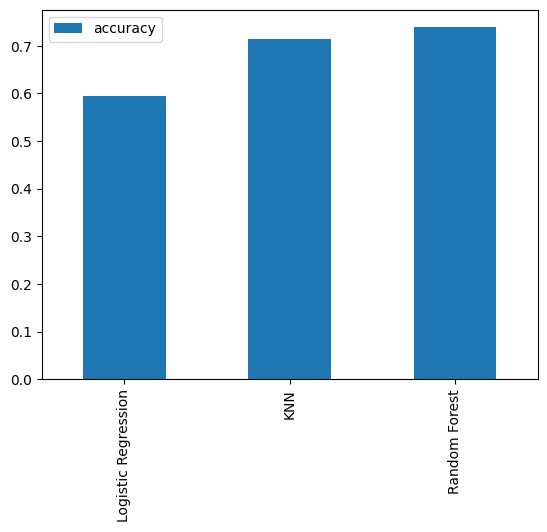

In [18]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar()

In [19]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1,20,2)}

In [20]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [21]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 4.281332398719396}

In [22]:
rs_log_reg.score(X_test, y_test)

0.7603414313854235

In [23]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier()
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
rs_rf.best_params_

In [ ]:
rs_rf.score(X_test, y_test)

In [24]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

#  Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=2)

# Fit hyperparameter search for logisticRegression
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .........................C=0.0001, solver=liblinear; total time=   0.0s
[CV] END .........................C=0.0001, solver=liblinear; total time=   0.0s
[CV] END .........................C=0.0001, solver=liblinear; total time=   0.0s
[CV] END .........................C=0.0001, solver=liblinear; total time=   0.0s
[CV] END .........................C=0.0001, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END ..........C=0.0003562247890262444, solver=liblinear; total time=   0.0s
[CV] END ..........C=0.0003562247890262444, sol

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=2)

In [25]:
# Check the best hyperparameters
gs_log_reg.best_params_

{'C': 9.236708571873866, 'solver': 'liblinear'}

In [26]:
# Evaluate the hyperparameter search for LogisticRegression
gs_log_reg.score(X_test, y_test)

0.7590282337491793

## Evaluating our tuned machine learing classifier, beyond accuracy
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

In [27]:
# Make predictions with tuned model
y_preds = gs_log_reg.predict(X_test)

In [28]:
y_preds

array([0, 0, 1, ..., 0, 1, 0])

In [29]:
y_test

,target
5367,0
3688,1
6604,1
3343,0
5881,1
...,...
1070,1
1940,0
6551,0
1393,1


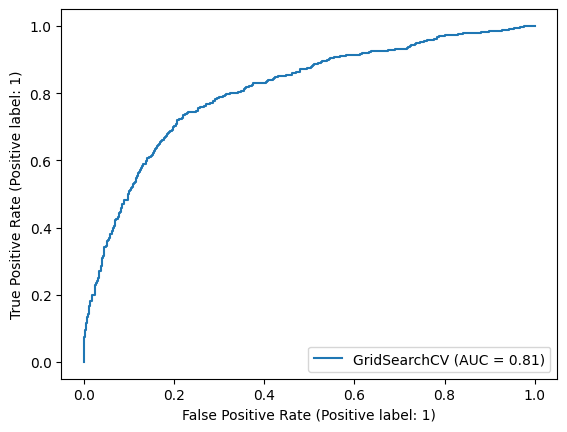

In [30]:
# Plot ROC curve and calculate AUC metric
RocCurveDisplay.from_estimator(gs_log_reg, X_test, y_test);

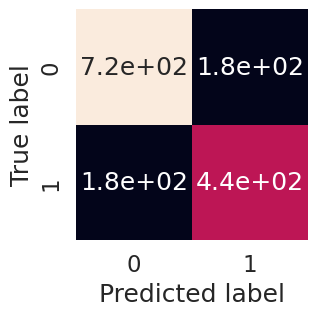

In [31]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

plot_conf_mat(y_test, y_preds)

In [32]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       904
           1       0.70      0.70      0.70       619

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



### Calculate evaluation metrics using cross-validation

In [33]:
gs_log_reg.best_params_

{'C': 9.236708571873866, 'solver': 'liblinear'}

In [34]:
# new model with best params
clf = LogisticRegression(C = 1.3738237958832638,
                         solver = "liblinear")

In [35]:
# Cross-validated f1-score
cv_f1 = cross_val_score(clf,
                         transformed_X,
                         y,
                         cv=5,
                         scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.18946954629241253

In [36]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.3738237958832638, solver='liblinear')

In [37]:
clf.coef_

array([[ 3.42359609e-01,  1.21296491e+00, -1.72200057e+00, ...,
         2.32055381e-01, -1.57070436e-01,  4.47824228e-05]])

In [39]:
# Match coef's of features to columns
feature_dict = dict(zip(train_data.columns, list(clf.coef_[0])))
feature_dict

{'id': 0.34235960886904215,
 'keyword': 1.2129649135763554,
 'location': -1.7220005728803174,
 'text': 1.950889151892037,
 'target': 0.7324579925990257}